In [1]:
from PyPDF2 import PdfReader
import re
import os
from getpass import getpass

import nltk
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from langchain_text_splitters import CharacterTextSplitter
from langchain_community.embeddings.huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores.faiss import FAISS
from langchain.memory import ConversationBufferMemory
from langchain.chains.conversational_retrieval.base import ConversationalRetrievalChain
from langchain.llms.huggingface_hub import HuggingFaceHub

In [2]:
def extract_text(pdf_docs):
    text=""
    for pdf in pdf_docs:
        pdf_reader = PdfReader(pdf)
        for page in pdf_reader.pages:
            text+=page.extract_text()
    return text

In [3]:
# pdf_docs = [r'data\ramayan_summary.pdf', r'data\mahabharat_summary.pdf']
pdf_docs = [r'data\ramayan_summary.pdf']


In [4]:
raw_text = extract_text(pdf_docs=pdf_docs)

In [5]:
raw_text

'Ramayana Short Summary  \n  \n Dasharatha is the King of Ayodhya and has three wives and four sons, Rama,  \n Lakshmana, Bharata and Shatrughana. Rama is the ideal and perfect son, and grows  \n up with his brothers. When he comes of age, he marries Sita, the princess of a nearby  \n kingdom. However, Bharata\'s mother is Kaikeyi, who resents Rama being the crown  \n prince. She calls up a debt that Dasharatha owes her and asks for Rama to be exiled  \n for fourteen years and her son Bharata be made crown prince instead.  \n The devastated Dasharatha has no choice and Rama prepares to leave for exile. Sita  \n and Lakshmana will not leave his side however and follow him into the forest. While in  \n the forest, Surphanaka, a female rakshasi (demoness) becomes enamored of Rama  \n and is wounded by Lakshmana while trying to kill Sita. She flees to her brother Khara  \n and asks him to avenge her. However, Khara and his army are defeated by Rama and  \n Lakshmana, and only one member of

In [6]:
def clean_text(text):
    # Remove unwanted characters
    clean_text = re.sub(r'\n', ' ', text)
    
    # Remove apostrophes
    clean_text = re.sub(r"'", '', clean_text)
    
    # Normalize whitespace
    clean_text = re.sub(r'\s+', ' ', clean_text)
    
    return clean_text

In [7]:
text = clean_text(raw_text)

In [8]:
text

'Ramayana Short Summary Dasharatha is the King of Ayodhya and has three wives and four sons, Rama, Lakshmana, Bharata and Shatrughana. Rama is the ideal and perfect son, and grows up with his brothers. When he comes of age, he marries Sita, the princess of a nearby kingdom. However, Bharatas mother is Kaikeyi, who resents Rama being the crown prince. She calls up a debt that Dasharatha owes her and asks for Rama to be exiled for fourteen years and her son Bharata be made crown prince instead. The devastated Dasharatha has no choice and Rama prepares to leave for exile. Sita and Lakshmana will not leave his side however and follow him into the forest. While in the forest, Surphanaka, a female rakshasi (demoness) becomes enamored of Rama and is wounded by Lakshmana while trying to kill Sita. She flees to her brother Khara and asks him to avenge her. However, Khara and his army are defeated by Rama and Lakshmana, and only one member of their entire army survives. This lone soldier flees t

In [9]:
def get_most_frequent_words(text, num_words=30, common_words=None):
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    if common_words is not None:
        stop_words.update(common_words)
        
    all_words = ''.join(text).split()
    filtered_words = [word for word in all_words if word not in stop_words]
    word_freq = Counter(filtered_words)
    most_common_words = word_freq.most_common(num_words)
    return most_common_words

In [10]:
most_freq_words = get_most_frequent_words(text=text)

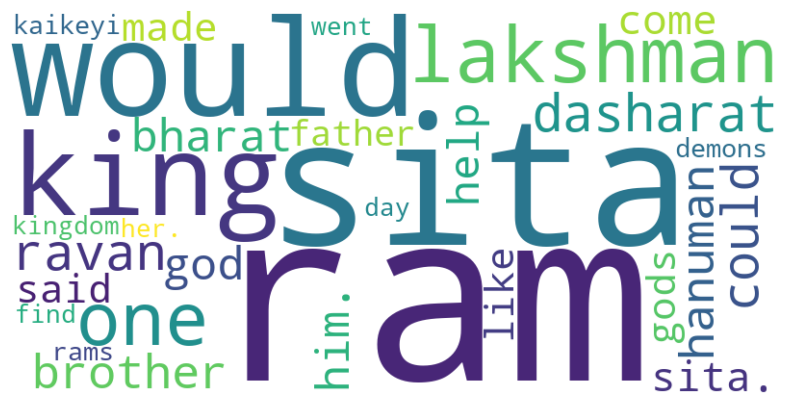

In [11]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_freq_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
def chunking(text):
    text_splitter = CharacterTextSplitter(separator='\n',chunk_size=1200,chunk_overlap=400,length_function=len)
    chunks = text_splitter.split_text(text)
    return chunks

In [13]:
chunks = chunking(raw_text)

In [14]:
print(len(chunks), chunks[1], chunks[2], sep='\n'+'-'*100+'\n')

44
----------------------------------------------------------------------------------------------------
and is wounded by Lakshmana while trying to kill Sita. She flees to her brother Khara  
 and asks him to avenge her. However, Khara and his army are defeated by Rama and  
 Lakshmana, and only one member of their entire army survives. This lone soldier flees  
 to the island kingdom of Lanka and begs Surphanaka's brother, the mighty king Ravana  
 to avenge them. Ravana has heard of Sita's beauty and he decides to abduct her. Using  
 trickery and magic, he manages to lure Rama and Lakshmana away from Sita and  
 kidnaps her, taking her away to Lanka.
  
 Ravana kidnaps Sita and slays Jatayu.  
 Rama and Lakshmana travel far and wide searching for Sita but to no avail. Finally, they  
 come upon a band of vanaras or monkey-men who pledge to help him. One of the might  
 warriors of the vanaras, Hanuman, becomes Rama's staunch devotee. The vanaras  
 seek out traces of Sita and find s

In [15]:
def embeddings(chunks):
    embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
    faiss = FAISS.from_texts(texts=chunks, embedding=embedding_model)
    return faiss

In [16]:
vector_store = embeddings(chunks)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

C:\Users\rachi\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rachi\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [17]:
relevant_context = vector_store.similarity_search_with_relevance_scores(query="Who was Bharata's mother and what did she resents?", k=3)

In [18]:
for context in relevant_context:
    print(f"Similarity score: {context[1]}")
    print(context[0].page_content)
    print("-"*60)

Similarity score: 0.4292526458215369
was utterly worn down. He was distressed by the idea of losing his beloved son in his  
 own old age, and could not bring himself to speak to Ram when the young prince came  
 to get his blessing before the coronation.  
 Ram was concerned, 'Have I upset my father'' he wondered, then looking at Kaikeyi's  
 harsh expression, he asked.  
 'Have I displeased the king' Tell me mother, why does my father looks so dejected''  
 'Then listen, Ram,' replied Kaikeyi sternly. 'Your father loves you more than even his  
 honour so he hesitates to command you to go into exile for fourteen years, while Bharat  
 is crowned and established king of Ayodhya.' 'Thank you for telling me mother,' Ram  
 said. 'There is no greater virtue than to obey one's parents. I will leave immediately.  
 Bharat will make an able king.'  
 Ram sadly said farewell to his heartbroken father and then went to Queen Kaushaliya,  
 his real mother, to say goodbye to her. He explained h

In [19]:
HUGGINGFACEHUB_API_TOKEN = getpass()

 ········


In [23]:
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HUGGINGFACEHUB_API_TOKEN

In [24]:
# template = """You are epicchat, a chatbot created by rachit. You are trained of the english translations of Ramayana and Mahabharata. Give the following conversation and the input question I want you to answer the question to the best of your ability with the relevant knowledge you are trained on. If you do not have an answer respond honestly your lack of knowledge.
# Histrot:\n{{chat_history}}\nInput Question:\n{{input_question}}
# """

# prompt = PromptTemplate(input_variables=['chat_history', 'input_question'], template=template)
def get_conversation_chain(vector_store):
    repo_id="google/gemma-1.1-2b-it"
    llm = HuggingFaceHub(repo_id=repo_id, huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN,  model_kwargs={'temperature':0.5, 'max_length':128})
    memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True, ai_prefix='epicschat', human_prefix='curioushuman')
    retriever = vector_store.as_retriever()
    conv_chain = ConversationalRetrievalChain.from_llm(
        llm=llm,
        retriever=retriever,
        memory=memory,
    )
    return conv_chain

In [25]:
conversation_chain = get_conversation_chain(vector_store)

C:\Users\rachi\AppData\Local\Programs\Python\Python310\lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.llms.huggingface_hub.HuggingFaceHub` was deprecated in langchain-community 0.0.21 and will be removed in 0.2.0. Use HuggingFaceEndpoint instead.
  warn_deprecated(


In [28]:
query = "Who was Bharata's mother and what did she resents?"
response = conversation_chain({'question':query})

C:\Users\rachi\AppData\Local\Programs\Python\Python310\lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


In [29]:
response

{'question': "Who was Bharata's mother and what did she resents?",
 'chat_history': [HumanMessage(content="Who was Bharata's mother and what did she resents?"),
  AIMessage(content="Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.\n\nwas utterly worn down. He was distressed by the idea of losing his beloved son in his  \n own old age, and could not bring himself to speak to Ram when the young prince came  \n to get his blessing before the coronation.  \n Ram was concerned, 'Have I upset my father'' he wondered, then looking at Kaikeyi's  \n harsh expression, he asked.  \n 'Have I displeased the king' Tell me mother, why does my father looks so dejected''  \n 'Then listen, Ram,' replied Kaikeyi sternly. 'Your father loves you more than even his  \n honour so he hesitates to command you to go into exile for fourteen years, while Bharat  \n is crowned and established king of A

In [30]:
query = "What did Vishnu give to Dasharat so that his wife could bear sons?"
response = conversation_chain({'question':query})

In [48]:
response['chat_history'][1].pretty_print()

================================== Ai Message ==================================

Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

was utterly worn down. He was distressed by the idea of losing his beloved son in his  
 own old age, and could not bring himself to speak to Ram when the young prince came  
 to get his blessing before the coronation.  
 Ram was concerned, 'Have I upset my father'' he wondered, then looking at Kaikeyi's  
 harsh expression, he asked.  
 'Have I displeased the king' Tell me mother, why does my father looks so dejected''  
 'Then listen, Ram,' replied Kaikeyi sternly. 'Your father loves you more than even his  
 honour so he hesitates to command you to go into exile for fourteen years, while Bharat  
 is crowned and established king of Ayodhya.' 'Thank you for telling me mother,' Ram  
 said. 'There is no greater virtue than to obey one's parent